# PySpark Linear Regression - Housing Prices Dataset

- **Dataset link:** https://www.kaggle.com/datasets/yasserh/housing-prices-dataset/data
- **Author:** brenoAV
- **Last date modified:** 11/13/2023

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.linalg import Vectors
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import numpy as np

In [2]:
plt.rcParams['figure.figsize'] = [10,6]

In [3]:
spark = SparkSession.builder.appName("Practice").getOrCreate()

23/11/13 21:33:04 WARN Utils: Your hostname, debian resolves to a loopback address: 127.0.1.1; using 10.0.0.183 instead (on interface eno1)
23/11/13 21:33:04 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/13 21:33:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
df = spark.read.csv("/home/brenoav/Datasets/housing_prices_dataset/Housing.csv", header=True, inferSchema=True)
df.show()

+--------+-----+--------+---------+-------+--------+---------+--------+---------------+---------------+-------+--------+----------------+
|   price| area|bedrooms|bathrooms|stories|mainroad|guestroom|basement|hotwaterheating|airconditioning|parking|prefarea|furnishingstatus|
+--------+-----+--------+---------+-------+--------+---------+--------+---------------+---------------+-------+--------+----------------+
|13300000| 7420|       4|        2|      3|     yes|       no|      no|             no|            yes|      2|     yes|       furnished|
|12250000| 8960|       4|        4|      4|     yes|       no|      no|             no|            yes|      3|      no|       furnished|
|12250000| 9960|       3|        2|      2|     yes|       no|     yes|             no|             no|      2|     yes|  semi-furnished|
|12215000| 7500|       4|        2|      2|     yes|       no|     yes|             no|            yes|      3|     yes|       furnished|
|11410000| 7420|       4|        1

## Data exploration

## Checking NaN and null values

In [5]:
nan_df = df.agg(*[F.count(F.when(F.isnan(col) | F.isnull(col), col)).alias(col) for col in df.columns])
nan_df.show()

+-----+----+--------+---------+-------+--------+---------+--------+---------------+---------------+-------+--------+----------------+
|price|area|bedrooms|bathrooms|stories|mainroad|guestroom|basement|hotwaterheating|airconditioning|parking|prefarea|furnishingstatus|
+-----+----+--------+---------+-------+--------+---------+--------+---------------+---------------+-------+--------+----------------+
|    0|   0|       0|        0|      0|       0|        0|       0|              0|              0|      0|       0|               0|
+-----+----+--------+---------+-------+--------+---------+--------+---------------+---------------+-------+--------+----------------+



There are no NaN values or null values

## Numeric values

In [6]:
numeric_features = ["area", "price"]

In [7]:
mean_df = df.agg(*[F.mean(col).alias(col) for col in numeric_features])
std_df = df.agg(*[F.std(col).alias(col) for col in numeric_features])
mean_df.show()
std_df.show()

+----------------+-----------------+
|            area|            price|
+----------------+-----------------+
|5150.54128440367|4766729.247706422|
+----------------+-----------------+

+------------------+------------------+
|              area|             price|
+------------------+------------------+
|2170.1410225088025|1870439.6156573943|
+------------------+------------------+



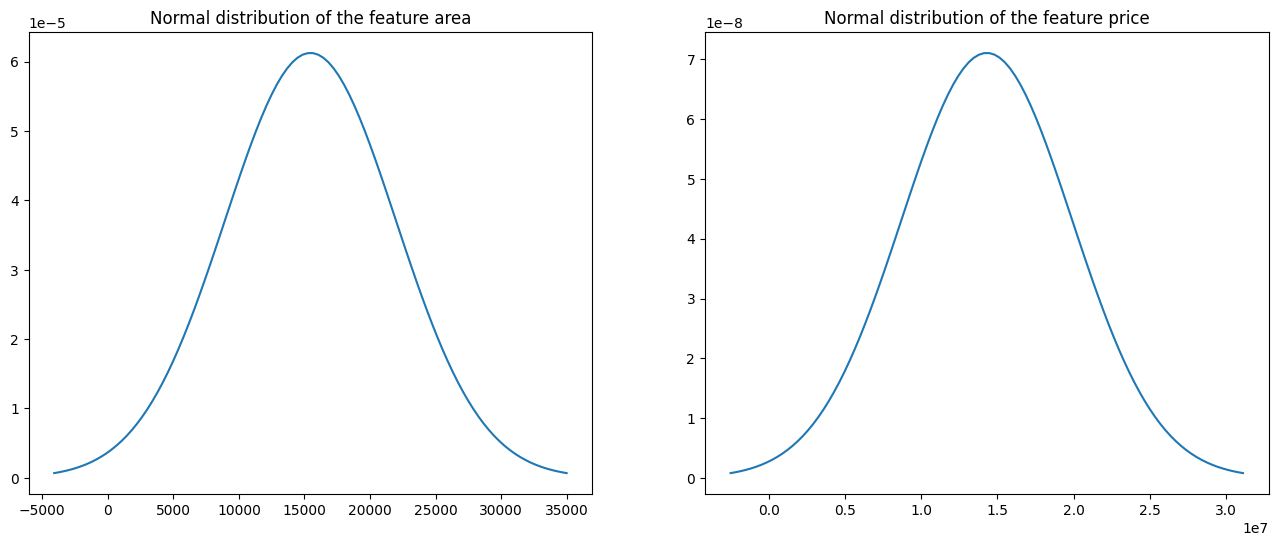

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
for i, numeric_feature in enumerate(numeric_features):
    mean = 3*mean_df.select(numeric_feature).collect()[0][numeric_feature]
    std = 3*std_df.select(numeric_feature).collect()[0][numeric_feature]
    axes[i].set_title(f"Normal distribution of the feature {numeric_feature}")
    x = np.linspace(mean - 3*std, mean + 3*std, 100)
    axes[i].plot(x, norm.pdf(x=x, loc=mean, scale=std))

In [9]:
df.describe(numeric_features).show()

+-------+------------------+------------------+
|summary|              area|             price|
+-------+------------------+------------------+
|  count|               545|               545|
|   mean|  5150.54128440367| 4766729.247706422|
| stddev|2170.1410225088025|1870439.6156573943|
|    min|              1650|           1750000|
|    max|             16200|          13300000|
+-------+------------------+------------------+



The target variable has a huge variance, could be difficult to predict.

## Categorical Variables

In [10]:
categorical_features = [
    "bedrooms",
    "bathrooms",
    "stories",
    "mainroad",
    "guestroom",
    "basement",
    "hotwaterheating",
    "airconditioning",
    "parking",
    "prefarea",
    "furnishingstatus"
]

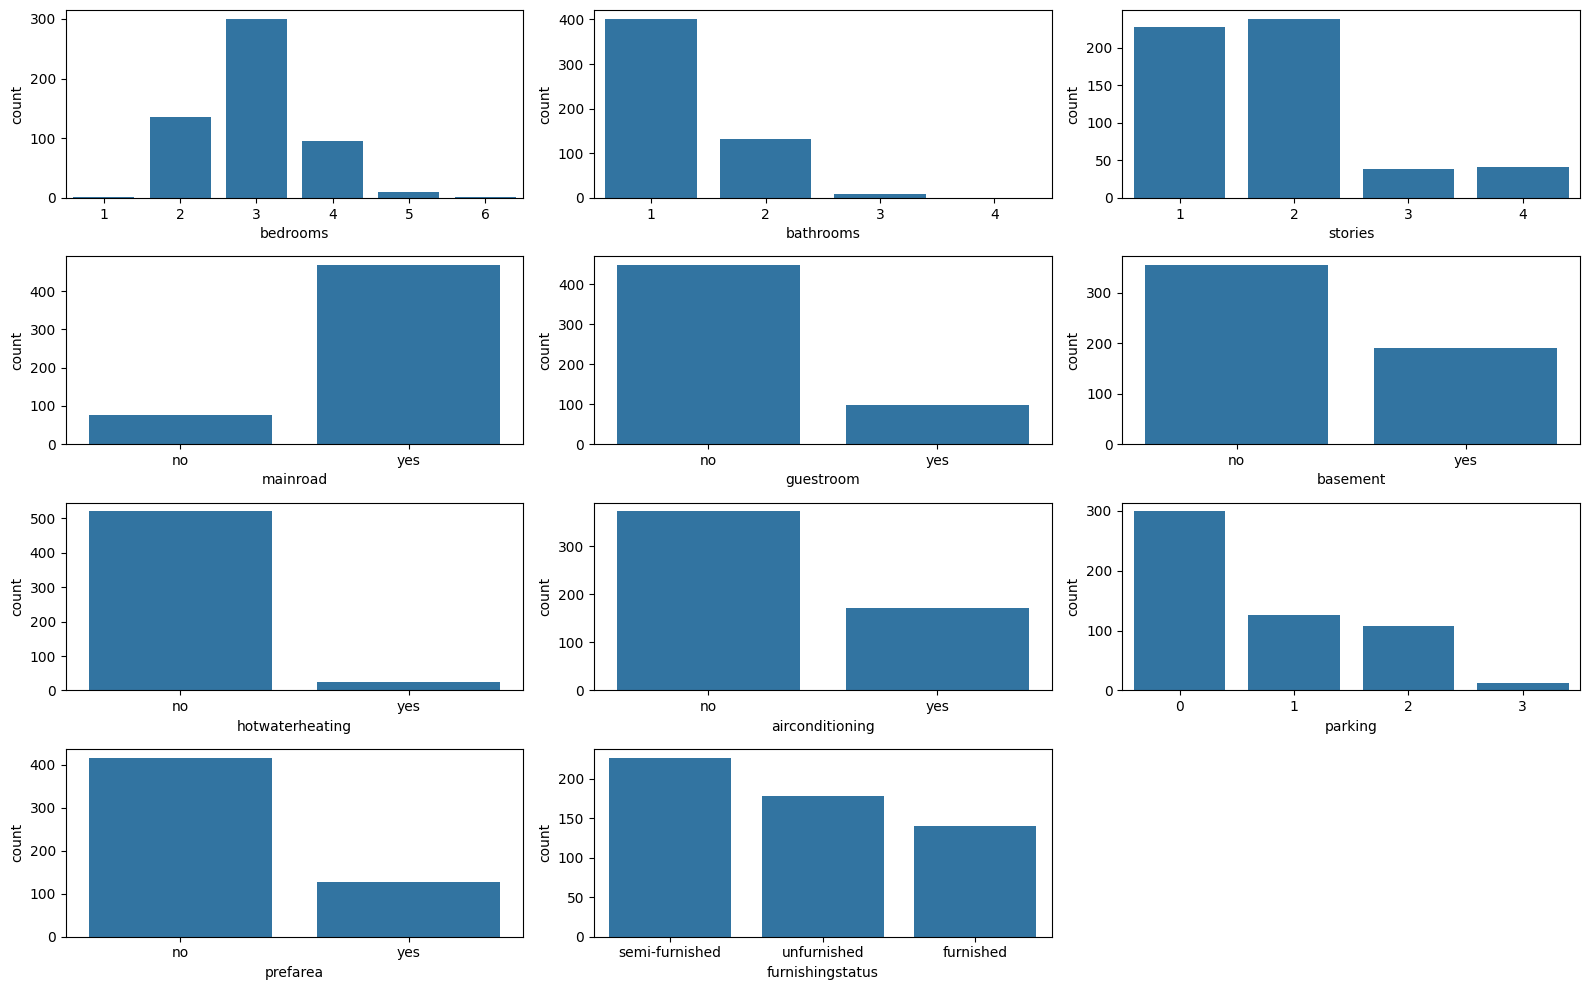

In [11]:
plt.figure(figsize=(16, 10))
for i, feature in enumerate(categorical_features, start=1):
    bedrooms_barplot = df.groupby(feature).count().toPandas()
    plt.subplot(4, 3, i)
    sns.barplot(x=bedrooms_barplot[feature], y=bedrooms_barplot["count"])

plt.tight_layout()
plt.show()

The dataset is not balanced for all features.

# Data Manipulation

## Numeric 

In [12]:
df = df.withColumn("area_scaled", (df["area"] - df.agg(F.mean("area")).first()[0])/df.agg(F.stddev("area")).first()[0])

## Categorical

In [13]:
string_indexer = StringIndexer(inputCols=["mainroad", "guestroom", "basement", "hotwaterheating", 
                                          "airconditioning", "prefarea", "furnishingstatus"],
                               outputCols=["num_mainroad", "num_guestroom", "num_basement", 
                                           "num_hotwaterheating", "num_airconditioning", 
                                           "num_prefarea", "num_furnishingstatus"])

In [14]:
df = string_indexer.fit(df).transform(df)
df.select(["price", "area_scaled", "num_mainroad", "num_guestroom", 
            "num_basement", "num_hotwaterheating", "num_airconditioning", 
            "num_prefarea", "num_furnishingstatus"]).show()

+--------+-------------------+------------+-------------+------------+-------------------+-------------------+------------+--------------------+
|   price|        area_scaled|num_mainroad|num_guestroom|num_basement|num_hotwaterheating|num_airconditioning|num_prefarea|num_furnishingstatus|
+--------+-------------------+------------+-------------+------------+-------------------+-------------------+------------+--------------------+
|13300000| 1.0457655479793246|         0.0|          0.0|         0.0|                0.0|                1.0|         1.0|                 2.0|
|12250000| 1.7553968502896582|         0.0|          0.0|         0.0|                0.0|                1.0|         0.0|                 2.0|
|12250000|   2.21619639724442|         0.0|          0.0|         1.0|                0.0|                0.0|         1.0|                 0.0|
|12215000| 1.0826295117357057|         0.0|          0.0|         1.0|                0.0|                1.0|         1.0|       

In [15]:
df.columns

['price',
 'area',
 'bedrooms',
 'bathrooms',
 'stories',
 'mainroad',
 'guestroom',
 'basement',
 'hotwaterheating',
 'airconditioning',
 'parking',
 'prefarea',
 'furnishingstatus',
 'area_scaled',
 'num_mainroad',
 'num_guestroom',
 'num_basement',
 'num_hotwaterheating',
 'num_airconditioning',
 'num_prefarea',
 'num_furnishingstatus']

In [16]:
vecAssembler = VectorAssembler(inputCols=["bedrooms", "bathrooms", 
                                          "stories", "area_scaled", "num_mainroad", "num_guestroom", 
                                          "num_basement", "num_hotwaterheating", "num_airconditioning", 
                                          "parking", "num_prefarea", "num_furnishingstatus"], outputCol="features")

In [17]:
output_df = vecAssembler.transform(df)
output_df.show()

+--------+-----+--------+---------+-------+--------+---------+--------+---------------+---------------+-------+--------+----------------+-------------------+------------+-------------+------------+-------------------+-------------------+------------+--------------------+--------------------+
|   price| area|bedrooms|bathrooms|stories|mainroad|guestroom|basement|hotwaterheating|airconditioning|parking|prefarea|furnishingstatus|        area_scaled|num_mainroad|num_guestroom|num_basement|num_hotwaterheating|num_airconditioning|num_prefarea|num_furnishingstatus|            features|
+--------+-----+--------+---------+-------+--------+---------+--------+---------------+---------------+-------+--------+----------------+-------------------+------------+-------------+------------+-------------------+-------------------+------------+--------------------+--------------------+
|13300000| 7420|       4|        2|      3|     yes|       no|      no|             no|            yes|      2|     yes| 

In [18]:
output_df = output_df.select(["features", "price"])
output_df.show()

+--------------------+--------+
|            features|   price|
+--------------------+--------+
|[4.0,2.0,3.0,1.04...|13300000|
|[4.0,4.0,4.0,1.75...|12250000|
|[3.0,2.0,2.0,2.21...|12250000|
|[4.0,2.0,2.0,1.08...|12215000|
|[4.0,1.0,2.0,1.04...|11410000|
|[3.0,3.0,1.0,1.08...|10850000|
|[4.0,3.0,4.0,1.58...|10150000|
|(12,[0,1,2,3,11],...|10150000|
|[4.0,1.0,2.0,1.35...| 9870000|
|[3.0,2.0,4.0,0.27...| 9800000|
|[3.0,1.0,2.0,3.70...| 9800000|
|[4.0,3.0,2.0,0.39...| 9681000|
|[4.0,2.0,2.0,0.64...| 9310000|
|[4.0,2.0,2.0,-0.7...| 9240000|
|(12,[0,1,2,3,10],...| 9240000|
|(12,[0,1,2,3,6,9]...| 9100000|
|[4.0,2.0,2.0,0.66...| 9100000|
|[3.0,2.0,4.0,1.54...| 8960000|
|[3.0,2.0,2.0,-0.2...| 8890000|
|[3.0,2.0,2.0,0.58...| 8855000|
+--------------------+--------+
only showing top 20 rows



# Split dataset train and test

- **!DISCLAIMER! Here is where we need to standardize the area feature in the training without the testing data.**

In [26]:
train_df, test_df = output_df.randomSplit([.8, .2], seed=123)

# Model - Linear Regression

In [27]:
regressor = LinearRegression(featuresCol="features", labelCol="price").fit(train_df)

23/11/13 21:39:52 WARN Instrumentation: [8065cc6d] regParam is zero, which might cause numerical instability and overfitting.


In [28]:
results = regressor.evaluate(test_df)

In [29]:
results.predictions.show()

+--------------------+-------+------------------+
|            features|  price|        prediction|
+--------------------+-------+------------------+
|(12,[0,1,2,3],[2....|3850000|  2848977.22346782|
|(12,[0,1,2,3],[2....|2870000| 3403499.517753795|
|(12,[0,1,2,3],[3....|3710000|3553465.8215449285|
|(12,[0,1,2,3],[3....|4515000| 4543868.430874297|
|(12,[0,1,2,3],[3....|2940000|4115532.5511909258|
|(12,[0,1,2,3],[4....|3290000|3532239.8397936756|
|(12,[0,1,2,3,4],[...|3255000|2541253.0335956966|
|(12,[0,1,2,3,4],[...|3675000| 2835278.808240353|
|(12,[0,1,2,3,4],[...|2485000| 2707790.879863136|
|(12,[0,1,2,3,4],[...|3010000| 2731003.441019293|
|(12,[0,1,2,3,4],[...|4410000|2957454.8709649146|
|(12,[0,1,2,3,4],[...|4200000| 4099762.207412037|
|(12,[0,1,2,3,4,6]...|2275000|2220863.8547297595|
|(12,[0,1,2,3,4,8]...|5145000|3630523.8460397185|
|(12,[0,1,2,3,4,11...|2135000|2170761.5409925883|
|(12,[0,1,2,3,4,11...|3353000| 2254578.820672451|
|(12,[0,1,2,3,5,6]...|3885000|3930925.3082450572|


In [34]:
mse = results.meanSquaredError
rmse = mse**(1/2)
r2 = results.r2

print("--- METRICS TEST DATA ---")
print(f"MSE = {mse:.2f}\nRMSE = {rmse:.2f}\nr2 = {r2:.4f}")

--- METRICS TEST DATA ---
MSE = 1208239381510.44
RMSE = 1099199.43
r2 = 0.6539


# Conclusion

This Jupyter is only to see the difference using the PySpark instead of [Scikit-learn Framework](https://scikit-learn.org/stable/), but the metrics are close to the "benchmark" as you can find here some notebooks: [Housing Prices Dataset - Dataset Notebooks](https://www.kaggle.com/datasets/yasserh/housing-prices-dataset/code?datasetId=1859421&sortBy=voteCount)